In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import seaborn as sns
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output

import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility

# Common modules

In [54]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_image(pred_batch, truth_batch, grid_len, debug=False):
        '''euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
        '''
        error = []
        for pred, truth in zip(pred_batch, truth_batch):
            pred, truth = pred[0], truth[0]  # there is only one channel
            indx = np.argmax(pred)
            pred_x = indx // grid_len
            pred_y = indx %  grid_len
            indx = np.argmax(truth)
            true_x = indx // grid_len
            true_y = indx %  grid_len
            err = Utility.distance_error((pred_x, pred_y), (true_x, true_y))
            if debug:
                print((pred_x, pred_y), (true_x, true_y), err)
            error.append(err)
        return error

---

# 1 Input is matrix, classification with 10K labels (area is 100x100)

In [4]:
# when the input is a matrix
class SensorInputDataset(Dataset):
    '''Sensor reading input dataset'''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))

    def __len__(self):
        return self.length * Default.sample_per_label

    def __getitem__(self, idx):
        folder   = self.oneDint2twoDstr(int(idx/Default.sample_per_label))
        matrix_name = str(idx%Default.sample_per_label) + '.txt'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        matrix = np.loadtxt(matrix_path, delimiter=',', dtype=float)
        if self.transform:
            matrix = self.transform(matrix)
        label = self.twoDstr2oneDint(folder)
        sample = {'matrix':matrix, 'label':label}
        return sample

    def oneDint2twoDstr(self, oneDint):
        '''convert a one dimension integer index to a two dimension string index'''
        x = oneDint // Default.grid_length
        y = oneDint % Default.grid_length
        return f'({x}, {y})'

    def twoDstr2oneDint(self, twoDstr):
        '''convert a two dimension string to a one dimension integet index for the labels'''
        twoDstr = twoDstr[1:-1]
        x, y = twoDstr.split(',')
        x, y = int(x), int(y)
        return x*Default.grid_length + y

In [55]:
class Net1(nn.Module):
    '''The output dimension of the full connnection layer is 100 x 100 = 10000
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.fc    = nn.Linear(15488, 10000)  # too many labels

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
# data

root_dir = './data/matrix-1'
tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

sensor_input_dataset = SensorInputDataset(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=4, shuffle=True, num_workers=4)

In [7]:
# training

net1      = Net1()
device    = torch.device('cuda')
model     = net1.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # criterion is the loss function

num_epochs = 3
train_losses = []
valid_accs = []
best_acc = 0
print_every = 200

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    for t, sample in enumerate(sensor_input_dataloader):
        model.train()
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')

epoch = 0
t = 0, loss = 9.200733184814453
t = 200, loss = 9.21034049987793
t = 400, loss = 9.21034049987793
t = 600, loss = 9.21034049987793
t = 800, loss = 9.21034049987793
t = 1000, loss = 9.21034049987793
t = 1200, loss = 9.21034049987793
t = 1400, loss = 9.21034049987793
t = 1600, loss = 9.21034049987793
t = 1800, loss = 9.21034049987793
t = 2000, loss = 9.21034049987793
t = 2200, loss = 9.21034049987793
t = 2400, loss = 9.21034049987793
t = 2600, loss = 9.21034049987793
t = 2800, loss = 9.21034049987793
t = 3000, loss = 9.21034049987793
t = 3200, loss = 9.21034049987793
t = 3400, loss = 9.21034049987793
t = 3600, loss = 9.21034049987793
t = 3800, loss = 9.21034049987793
t = 4000, loss = 9.21034049987793
t = 4200, loss = 9.21034049987793
t = 4400, loss = 9.21034049987793
t = 4600, loss = 9.21034049987793
t = 4800, loss = 9.21034049987793
epoch = 1
t = 0, loss = 9.21034049987793
t = 200, loss = 9.21034049987793
t = 400, loss = 9.21034049987793
t = 600, loss = 9.21034049987793
t = 80

# 2 Output is image, model as image segmentation problem

## In the output grid (image), the location with the TX is 1, all others are 0

## 2.1 Loss is nn.BCEWithLogitsLoss()

In [55]:
class SensorInputDatasetSegmentation(Dataset):
    '''Sensor reading input dataset
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        label = self.get_segmentation_output(folder)
        sample = {'matrix':matrix, 'label':label}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        return len(samples)

    def get_segmentation_output(self, folder: str):
        '''
        Args:
            folder -- example: 000001
        Return:
            np.ndarray, n = 2, the pixel with the TX is labeled 1, everywhere else is labeled 0
        '''
        twoDstr = glob.glob(os.path.join(self.root_dir, folder, '*.png'))[0]
        twoDstr = twoDstr.split('/')[4]
        twoDstr = twoDstr[1:-5]
        x, y = twoDstr.split(',')
        x, y = int(x), int(y)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        grid[x][y] = 1
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32)


tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

# training
root_dir = './data/matrix-train10'
sensor_input_dataset = SensorInputDatasetSegmentation(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_dataset[0]['matrix'].shape)
print(sensor_input_dataset[0]['label'])
print(sensor_input_dataset.__len__())

# testing
root_dir = './data/matrix-test10'
sensor_input_test_dataset = SensorInputDatasetSegmentation(root_dir = root_dir, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_test_dataset[0]['matrix'].shape)
print(sensor_input_test_dataset[0]['label'])
print(sensor_input_test_dataset.__len__())

torch.Size([1, 100, 100])
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
100000
torch.Size([1, 100, 100])
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
20000


In [56]:
# model

class Net2(nn.Module):
    '''The output dimension of the full connnection layer is 100 x 100 = 10000
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv2d(8, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 1, 5, padding=2)
        self.groupnorm1 = nn.GroupNorm(1, 8)
        self.groupnorm2 = nn.GroupNorm(1, 32)
        
    def forward(self, x):
#         x = F.relu(self.groupnorm1(self.conv1(x)))
#         x = F.relu(self.groupnorm2(self.conv2(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

net2 = Net2()
print(net2)

Net2(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (groupnorm1): GroupNorm(1, 8, eps=1e-05, affine=True)
  (groupnorm2): GroupNorm(1, 32, eps=1e-05, affine=True)
)


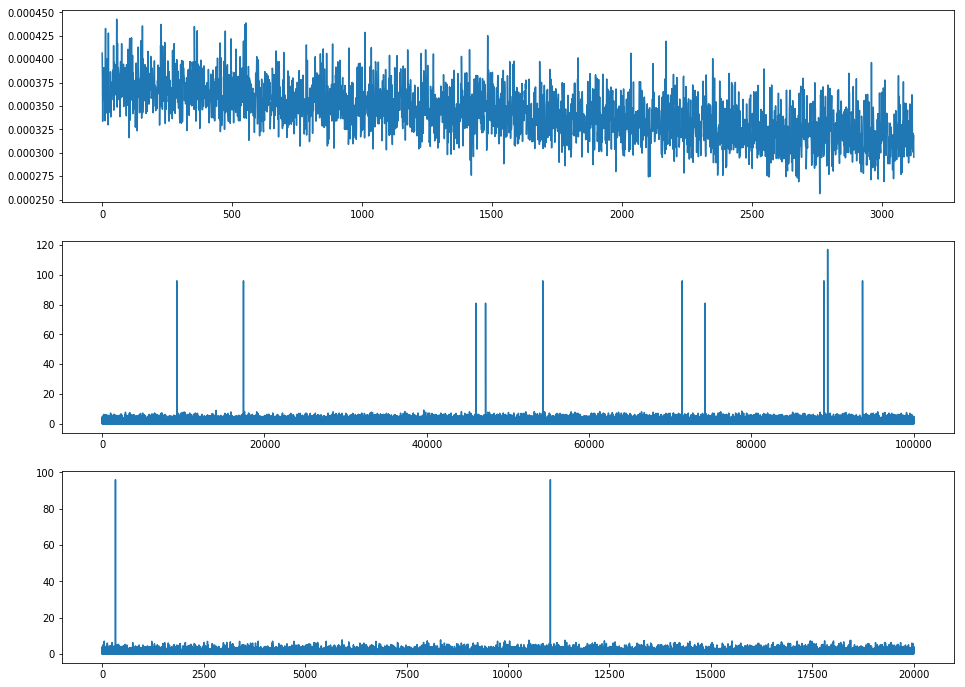

train loss mean = 0.00034287738570012153
train loss std  = 2.7387534257903526e-05
train mean = 1.299489010975439
train std  = 1.54211164004234
test mean = 1.182000746707738
test std  = 1.5510397270161553
train loss
(0.004499272188181058, 0.04279546575267773)
(0.00046979274463839827, 2.8598638358450708e-05)
(0.0004122393611632287, 3.0022492062670278e-05)
(0.00034287738570012153, 2.7387534257903526e-05)
train error
(19.48644029124558, 33.62410481746274)
(2.049218467335558, 5.6783090505123885)
(1.5375572162810152, 2.1580402699352432)
(1.299489010975439, 1.54211164004234)
test error
(2.502457227711397, 7.811892077049898)
(1.6257815229740693, 1.447129724508524)
(1.4550256263593442, 1.2734992841135007)
(1.182000746707738, 1.5510397270161553)


In [57]:
# 1 minute seconds per epoch

# %%time
# training segmentation problem

net2 = Net2()
print(net2)

device    = torch.device('cuda')
model     = net2.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # criterion is the loss function

num_epochs = 4
train_losses_epoch = []
train_errors_epoch = []
test_errors_epoch  = []
print_every = 500

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses = []
    train_errors = []
    test_errors  = []
    model.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pred = pred.data.cpu()
        y = y.data.cpu()
        train_errors.extend(Metrics.localization_error_image(pred, y, Default.grid_length))
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')
    
    model.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        pred = pred.data.cpu()
        y = y.data.cpu()
        test_errors.extend(Metrics.localization_error_image(pred, y, Default.grid_length))
    
    clear_output(True)
    plt.figure(figsize=(16, 12))
    plt.subplot(311)
    plt.plot(train_losses)
    plt.subplot(312)
    plt.plot(train_errors)
    plt.subplot(313)
    plt.plot(test_errors)
    plt.show()
    
    print('train loss mean =', np.mean(train_losses))
    print('train loss std  =', np.std(train_losses))
    print('train mean =', np.mean(train_errors))
    print('train std  =', np.std(train_errors))    
    print('test mean =', np.mean(test_errors))
    print('test std  =', np.std(test_errors))
    train_losses_epoch.append((np.mean(train_losses), np.std(train_losses)))
    train_errors_epoch.append((np.mean(train_errors), np.std(train_errors)))
    test_errors_epoch.append((np.mean(test_errors), np.std(test_errors)))

print('train loss')
for loss in train_losses_epoch:
    print(loss)
print('train error')
for error in train_errors_epoch:
    print(error)
print('test error')
for error in test_errors_epoch:
    print(error)

In [58]:
model.eval()
for t, sample in enumerate(sensor_input_dataloader):
    X = sample['matrix'].to(device)
    y = sample['label'].to(device)
    pred = model(X)
    print(np.mean(Metrics.localization_error_image(pred.data.cpu(), y.data.cpu(), Default.grid_length, True)))
    break

pred = pred.data.cpu().numpy()
y    = y.data.cpu().numpy()

(tensor(49), tensor(80)) (tensor(48), tensor(79)) 1.4142135623730951
(tensor(96), tensor(98)) (tensor(96), tensor(98)) 0.0
(tensor(7), tensor(78)) (tensor(7), tensor(78)) 0.0
(tensor(79), tensor(84)) (tensor(79), tensor(83)) 1.0
(tensor(64), tensor(33)) (tensor(64), tensor(34)) 1.0
(tensor(27), tensor(53)) (tensor(27), tensor(57)) 4.0
(tensor(74), tensor(27)) (tensor(73), tensor(28)) 1.4142135623730951
(tensor(86), tensor(97)) (tensor(86), tensor(99)) 2.0
(tensor(28), tensor(87)) (tensor(28), tensor(87)) 0.0
(tensor(74), tensor(44)) (tensor(74), tensor(43)) 1.0
(tensor(59), tensor(66)) (tensor(59), tensor(66)) 0.0
(tensor(91), tensor(83)) (tensor(91), tensor(83)) 0.0
(tensor(77), tensor(71)) (tensor(78), tensor(69)) 2.23606797749979
(tensor(74), tensor(36)) (tensor(74), tensor(35)) 1.0
(tensor(95), tensor(10)) (tensor(94), tensor(12)) 2.23606797749979
(tensor(16), tensor(52)) (tensor(15), tensor(52)) 1.0
(tensor(55), tensor(65)) (tensor(56), tensor(64)) 1.4142135623730951
(tensor(39), 

(32, 1, 100, 100)


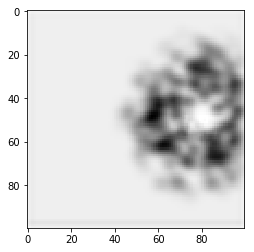

In [59]:
print(pred.shape)
i = 0
plt.imshow(pred[i, 0], cmap='gray')

In [60]:
pred2 = np.expand_dims(pred[i], axis=0)
y2    = np.expand_dims(pred[i], axis=0)
Metrics.localization_error_image(pred2, y2, Default.grid_length, True)

(49, 80) (49, 80) 0.0


[0.0]

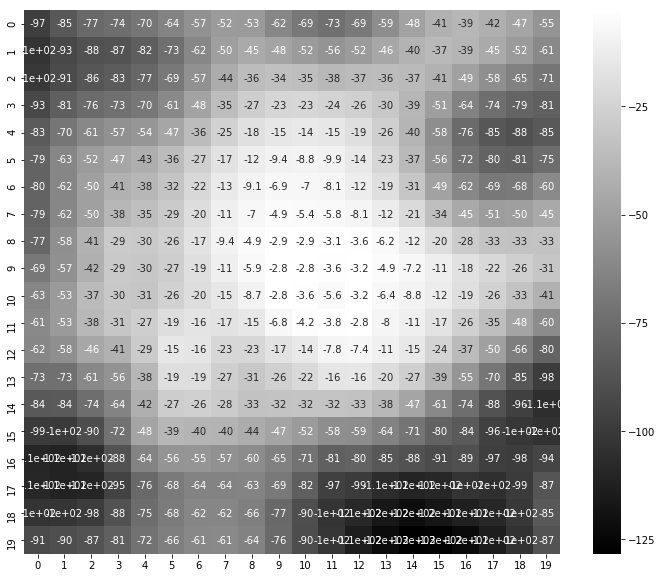

In [65]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pred2[i, 0][40:60, 70:90], cmap='gray', annot=True)

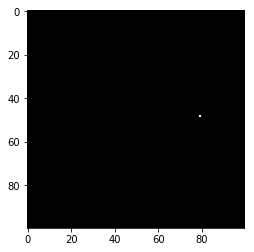

In [67]:
plt.imshow(y[i, 0], cmap='gray')

## 3.2 Loss is nn.MSELoss()

In [68]:
# training
root_dir = './data/matrix-train10'
sensor_input_dataset = SensorInputDatasetSegmentation(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_dataset[0]['matrix'].shape)
print(sensor_input_dataset[0]['label'])
print(sensor_input_dataset.__len__())

# testing
root_dir = './data/matrix-test10'
sensor_input_test_dataset = SensorInputDatasetSegmentation(root_dir = root_dir, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_test_dataset[0]['matrix'].shape)
print(sensor_input_test_dataset[0]['label'])
print(sensor_input_test_dataset.__len__())

torch.Size([1, 100, 100])
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
100000
torch.Size([1, 100, 100])
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
20000


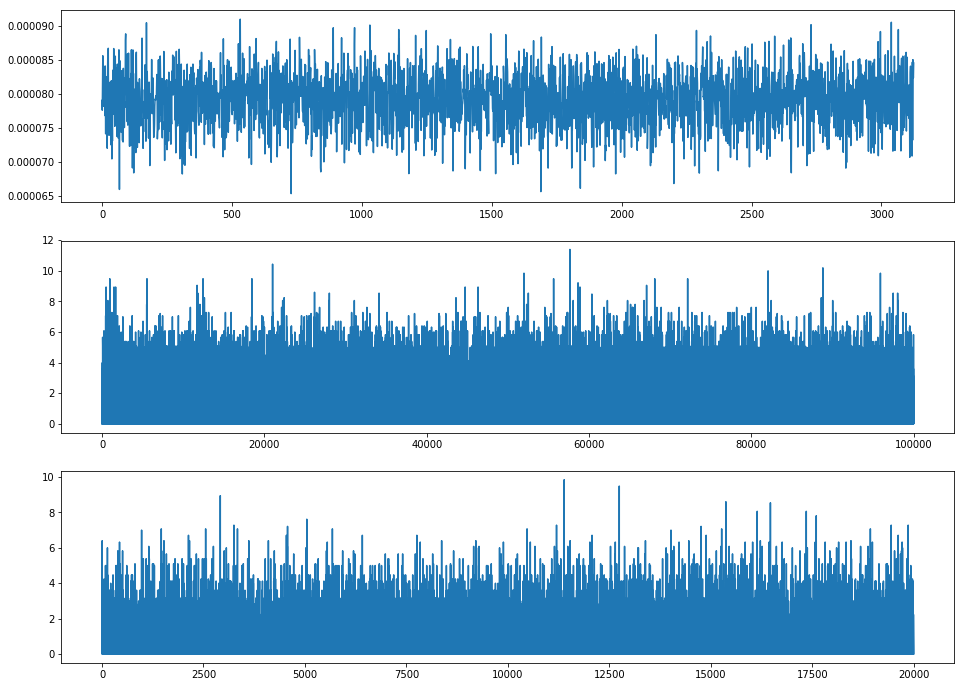

train loss mean = 7.910844565136358e-05
train loss std  = 3.805317616168622e-06
train mean = 1.0955231455868262
train std  = 1.3317466115907883
test mean = 1.0157157117435855
test std  = 1.2604251635528472
train loss
(9.509533832082525e-05, 1.0715052234254e-05)
(8.966100511606783e-05, 2.08117794048852e-06)
(8.656805372331291e-05, 2.7454544035635608e-06)
(8.427164746914059e-05, 3.1264148198214342e-06)
(8.266504037193954e-05, 3.264435020001081e-06)
(8.15810797479935e-05, 3.461052579361026e-06)
(8.07754019415006e-05, 3.573096212509819e-06)
(8.013887251727283e-05, 3.5971383532152323e-06)
(7.953877428080887e-05, 3.6842699528384706e-06)
(7.910844565136358e-05, 3.805317616168622e-06)
train error
(1.7147352810514473, 1.7396703469098431)
(1.302788726615361, 1.2805239294148028)
(1.2419667774002163, 1.3133691498714755)
(1.1983350629304315, 1.3222379048233035)
(1.168629799868091, 1.3271715755169964)
(1.1392111472213344, 1.3260799229483309)
(1.1227139944134668, 1.3319058850940475)
(1.10078479839539

In [69]:
# %%time
# segmentation problem

net2 = Net2()

device    = torch.device('cuda')
model     = net2.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # criterion is the loss function

num_epochs = 10
train_losses_epoch = []
train_errors_epoch = []
test_errors_epoch  = []
print_every = 500

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses = []
    train_errors = []
    test_errors  = []
    model.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pred = pred.data.cpu()
        y = y.data.cpu()
        train_errors.extend(Metrics.localization_error_image(pred, y, Default.grid_length))
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')
    
    model.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        pred = pred.data.cpu()
        y = y.data.cpu()
        test_errors.extend(Metrics.localization_error_image(pred, y, Default.grid_length))
    
    clear_output(True)
    plt.figure(figsize=(16, 12))
    plt.subplot(311)
    plt.plot(train_losses)
    plt.subplot(312)
    plt.plot(train_errors)
    plt.subplot(313)
    plt.plot(test_errors)
    plt.show()
    
    print('train loss mean =', np.mean(train_losses))
    print('train loss std  =', np.std(train_losses))
    print('train mean =', np.mean(train_errors))
    print('train std  =', np.std(train_errors))    
    print('test mean =', np.mean(test_errors))
    print('test std  =', np.std(test_errors))
    train_losses_epoch.append((np.mean(train_losses), np.std(train_losses)))
    train_errors_epoch.append((np.mean(train_errors), np.std(train_errors)))
    test_errors_epoch.append((np.mean(test_errors), np.std(test_errors)))

print('train loss')
for loss in train_losses_epoch:
    print(loss)
print('train error')
for error in train_errors_epoch:
    print(error)
print('test error')
for error in test_errors_epoch:
    print(error)

In [105]:
model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['label'].to(device)
    pred = model(X)
    errors = Metrics.localization_error_image(pred.data.cpu(), y.data.cpu(), Default.grid_length, True)
    print(np.mean(errors), np.std(errors))
    break

pred = pred.data.cpu().numpy()
y    = y.data.cpu().numpy()

(tensor(35), tensor(32)) (tensor(35), tensor(32)) 0.0
(tensor(23), tensor(35)) (tensor(23), tensor(35)) 0.0
(tensor(57), tensor(39)) (tensor(57), tensor(39)) 0.0
(tensor(44), tensor(73)) (tensor(44), tensor(73)) 0.0
(tensor(68), tensor(50)) (tensor(69), tensor(50)) 1.0
(tensor(3), tensor(95)) (tensor(1), tensor(98)) 3.605551275463989
(tensor(57), tensor(30)) (tensor(56), tensor(31)) 1.4142135623730951
(tensor(56), tensor(9)) (tensor(55), tensor(8)) 1.4142135623730951
(tensor(83), tensor(62)) (tensor(83), tensor(62)) 0.0
(tensor(56), tensor(49)) (tensor(56), tensor(49)) 0.0
(tensor(94), tensor(53)) (tensor(94), tensor(53)) 0.0
(tensor(46), tensor(90)) (tensor(47), tensor(89)) 1.4142135623730951
(tensor(54), tensor(51)) (tensor(54), tensor(51)) 0.0
(tensor(75), tensor(97)) (tensor(77), tensor(98)) 2.23606797749979
(tensor(3), tensor(16)) (tensor(2), tensor(14)) 2.23606797749979
(tensor(52), tensor(62)) (tensor(52), tensor(64)) 2.0
(tensor(44), tensor(62)) (tensor(44), tensor(62)) 0.0
(te

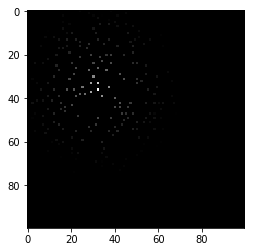

In [106]:
i = 0
plt.imshow(X[i, 0].data.cpu(), cmap='gray')

In [107]:
pred2 = np.expand_dims(pred[i], axis=0)
y2    = np.expand_dims(pred[i], axis=0)
Metrics.localization_error_image(pred2, y2, Default.grid_length, True)

(35, 32) (35, 32) 0.0


[0.0]

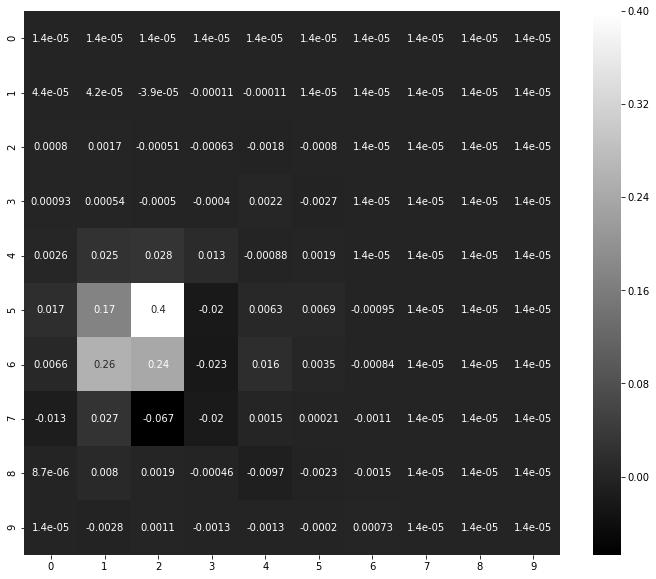

In [112]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pred2[i, 0][30:40, 30:40], cmap='gray', annot=True)

In [114]:
pred2[i, 0][35, 32]

0.39983737

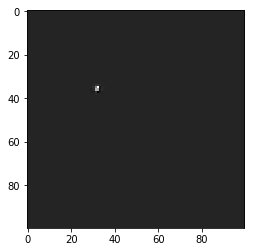

In [110]:
plt.imshow(pred[i, 0], cmap='gray')

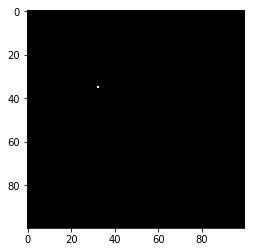

In [111]:
plt.imshow(y[i, 0], cmap='gray')

# Mics

In [81]:
a = [1, 2, 3]
b = [10, 11, 12]
c = [100, 101, 102]

for i, j, k in zip(a, b, c):
    print(i, j, k)

1 10 100
2 11 101
3 12 102
